### Import the Neccessary library and clone Retinanet Git

In [5]:
## Import all the library
import glob
import argparse
import xml.etree.ElementTree as ET
import os
import sys
import math
import glob
import argparse
import xml.etree.ElementTree as ET
from six.moves import urllib
import pandas as pd

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

In [2]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Clone the retina net git repositary**

In [4]:

!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 5893 (delta 3), reused 0 (delta 0), pack-reused 5885
Receiving objects: 100% (5893/5893), 13.41 MiB | 28.61 MiB/s, done.
Resolving deltas: 100% (3967/3967), done.
/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170843 sha256=81b444507d4fd0ee5069f215a7a7c7ee4cbc52a493cddd4d8ed4bef99619a69e
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=c210284419a6d096f51672baff3cf0d95ae09fd79cd341cf6272a4d8003c84cb
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet kera

### Create The dataset

**About the dataset**

1.   The dataset consist of dining Images.
2.  All the images are taken from google image 
1.   For Each image we have created xml and txt annotation through labelimg
2.   There are three classes in the dataset chair,table,vase
1.   We have manually split the data in train and test folder in 80,20 ratio







In [4]:
# file locations
# input - CHANGE THE DIR HERE TO TRAIN ON NEW DATA
train_data = '/content/drive/My Drive/Opencv_images/Train/'
test_data = '/content/drive/My Drive/Opencv_images/Test/'

#Output
train_annotations = './annotations.csv'
val_annotations = './val_annotations.csv'
label_file = './classes.csv'


1.   We will store the train and test image path in train and test data 
2.   The csv dataset  will be stored in train_annotation for train datset ,val_annotation for validaiton dataset and label_file for classes



In [5]:
# CONVERT the XML annotations to CSV format
def convert_annotation(train_data, test_data, image_id, filename, classes, train=False):
    if train:
        in_file = open(train_data + '%s.xml' % image_id)
    else:
        in_file = open(test_data + '%s.xml' % image_id)
    out_file = open(filename, 'a')
    tree = ET.parse(in_file)
    root = tree.getroot()

    if root.iter('object') is not None:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)

            xmlbox = obj.find('bndbox')
            x1 = math.ceil(float(xmlbox.find('xmin').text))
            y1 = math.ceil(float(xmlbox.find('ymin').text))
            x2 = math.ceil(float(xmlbox.find('xmax').text))
            y2 = math.ceil(float(xmlbox.find('ymax').text))
            if x1 == x2 or y1 == y2:
                continue
            if train:
                out_file.write(
                    f'{train_data + image_id}.jpg,{x1},{y1},{x2},{y2},{cls}\n')
            else:
                out_file.write(
                    f'{test_data + image_id}.jpg,{x1},{y1},{x2},{y2},{cls}\n')
    else:
        if train:
            out_file.write(f'{train_data + image_id}.jpg,,,,,\n')
        else:
            out_file.write(f'{test_data + image_id}.jpg,,,,,\n')


1.   Created a function convert_annotation that will take 6 parameter train_data, test_data, image_id, filename, classes, train=False
2.By default train is false ,that means only test dataset will be created ,if train is true only train data will be created 



In [21]:
# filter out the train test jpg files
train_image = glob.glob(train_data + '/*.jpg')

test_image = glob.glob(test_data + '/*.jpg')

# define the classes for the model
labels = ['chair', 'table', 'vase']

# create new annotation files for  Train/validation
open(train_annotations, 'w')
open(val_annotations, 'w')

#Extract the image name so as to pass it into function 
train_ids = [os.path.basename(i[:-4]) for i in train_image]

#Create the train dataset
for image_id in train_ids:
    convert_annotation(train_data, test_data, image_id, train_annotations, labels, train=True)

#Extract the image name so as to pass it into function
val_ids = [os.path.basename(i[:-4]) for i in test_image]

#Create the test dataset
for image_id in val_ids:
    convert_annotation(train_data, test_data, image_id, val_annotations, labels)

# creating classes file listing all classes
with open(label_file, 'w') as f:
    for i, line in enumerate(labels):
        f.write('{},{}\n'.format(line, i))

print('DONE')


DONE


The above code will create train ,test and class label dataset

In [22]:
#Create a training and test dataframe
dftrain = pd.read_csv(train_annotations,header=None)
dftrain.columns =   ['image_name','x_min','y_min','x_max','y_max','Classes']
dftest = pd.read_csv(val_annotations,header=None)
dftest.columns =   ['image_name','x_min','y_min','x_max','y_max','Classes']

In [23]:
#Print  the len of train and test data 
print("train_image_len",len(dftrain))
print("test_image_len",len(dftest))

train_image_len 782
test_image_len 201


### Train the model

In [18]:
# To create a new directory
os.makedirs("snapshots",exist_ok=True)
os.makedirs("logs",exist_ok=True)

In [19]:
#Store the pretrained model downloaded from the url in the snapshot folder
pretrained_model = ("./snapshots/_pretrained_model.h5")
url = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(url,pretrained_model)

('./snapshots/_pretrained_model.h5',
 <http.client.HTTPMessage at 0x7fa5b1ca7f98>)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

The above code will download resnet50 latest version from the URL to train the retinanet model

In [ ]:
#pretrained_model = ("./snapshots/_pretrained_model.h5")
#url = 'https://api.wandb.ai/syllogismos/keras-retinanet/1m1gxk8w/resnet101_coco_60.h5'
#urllib.request.urlretrieve(url,pretrained_model)

**Train the model**

Below are the step to train the model
1.  Download train.py file from keras retinest clone repository
2.   Use backbone as resnet50 and weight as pretrained model
1.  Use default random transform to perform the data augmentation .We can change the parameter as per our requirement
2.   Epoch is 25 and batch size 4.Steps taken are 800
1.   Image-min-side is 500 and max-side is 833 
2.   Learning rate is taken as 0.001
1.   Take file as CSV as our dataset is in csv format

1.   The Model was stopped at any epoch.This is because In the retinanet there is default early stopping callback ,so if model loss does not improve in subsequent epoch the training will stop 

**Commenting callback**

Since the model is stopped at 13 epoch ,Lets comment the code of early stopping callback from train.py and train the model again.Below is the commented code

    #if args.evaluation and validation_generator:
    #     callbacks.append(keras.callbacks.EarlyStopping(
    #         monitor    = 'mAP',
    #         patience   = 5,
    #         mode       = 'max',
    #         min_delta  = 0.01
    #     ))









In [25]:
!./keras_retinanet/bin/train.py --backbone='resnet50' --weights {pretrained_model} --random-transform --batch-size=4 --steps 800 --epochs 25 --image-min-side 500 --image-max-side 833 --lr 0.001 --weighted-average csv annotations.csv classes.csv --val-annotations val_annotations.csv

Using TensorFlow backend.
2020-07-30 09:39:30.385978: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-07-30 09:39:32.610537: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-30 09:39:32.632884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-30 09:39:32.633844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-07-30 09:39:32.633891: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
20

Result:
1.   The best map we got is 0.2360 in the 19th epoch. Since in the dataset the classes are not easily separable and they are overlaping a lot we are getting low map  
2.   Precision in validation dataset for each classes are

    141 instances of class chair with average precision: 
    0.1653
    
    41 instances of class table with average precision: 
    0.3541
    
    19 instances of class vase with average precision: 0.5051
    
    mAP: 0.2360








### Inference

**Load the Model**

In [6]:
model_path='/content/drive/My Drive/Open CV/resnet50_csv_19.h5'
# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

1.The above code will take the best model and it will load the weight of the model with backbone as resnet50

**Create a function that will take image as an input and print the box ,score and label in that image**

In [7]:
def img_inference(img_path): 
  image = read_image_bgr(img_path)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      print(score)
      #Score is greater than thres_score break the loop else proceed
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [8]:
#Read classes csv file and  create a dicitonary of classes with there label
labels_to_names = pd.read_csv('/content/drive/My Drive/Open CV/classes.csv',header=None).T.loc[0].to_dict()

**Pass the image in the image inference function**
1.   We have used thresold here so if our score is less than the thresold we will not consider that  object in our object detection
2.   model.predict_on_batch is used to predict the classes.
1.   It will give tuple of three value boxes ,score and label
2.   We will check the score and if score is greter then thresold we will not consider that label/score/boxes for object detection 

**Prediction on Test Image**

processing time:  4.338714122772217
0.7226849
0.6891317
0.47287485
0.47006875
0.42296654
0.41367143
0.41089052
0.3851884
0.38084656
0.36243963


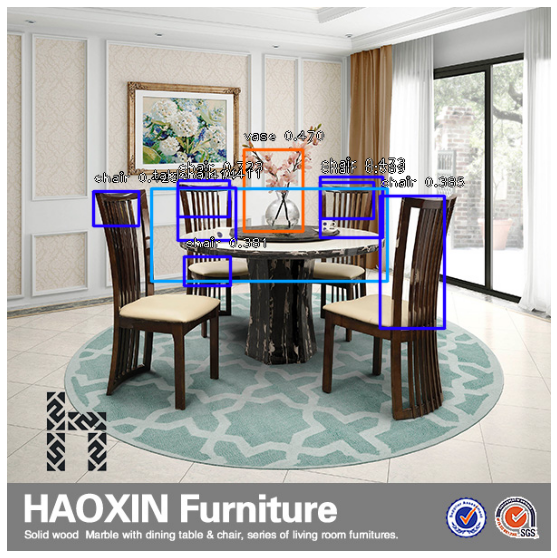

In [10]:
#Define the thresold
THRES_SCORE = 0.38

#Get the image path
img_infer = '/content/drive/My Drive/Opencv_images/image1.jpg'

#Call the fucntion
img_inference(img_infer)

Frome the above result One can see Chair ,table,vase are predicted correctly